<a href="https://colab.research.google.com/github/rnayebi21/PolygenceMLResearch-scRNAseq/blob/main/Gene_Expression_Models%2C_T_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the necessary imports and packages

In [1]:
!pip install pingouin

     |████████████████████████████████| 225kB 5.9MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.8-cp36-none-any.whl size=221687 sha256=dc8d6b2ad121a3a4aa8dfbfe4b49b64163cb549d891553324e1f39d29ce2befe
  Stored in directory: /root/.cache/pip/wheels/d6/9e/53/f885f73f29cf7c8cac3d8f4b1532bbfef2f5eb543946ac9055
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4961 sha256=01d69669e58d12cd6075eb8f9317e5e4bd6d90060383bb8dd1cb6bb443d73122
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7051 sha256=330b370bfc179e9738e3c18784c99d630a12c34548ef093a1f854fec766190a9
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import seaborn as sns
import pingouin as pg
from collections import Counter

from sklearn import metrics
from sklearn import model_selection, linear_model
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier 


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

sns.set()

Logging into google drive and accessing the files

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Gathering the metadata from google drive via the IDs of each google file

In [ ]:
T_cell_metadata_ID = "1Fo2aLizvnvpOPK10MRJFyWBddFkBPuaf"
T_file = drive.CreateFile({'id':T_cell_metadata_ID})
T_file.GetContentFile('cells_all_scp.txt')
T_metadata = pd.read_csv("cells_all_scp.txt", sep = "\t")


For later we will also want to have the gene expression data

In [ ]:
T_gene_expression_ID = "18yyfxNJhE5R1JDO3Cw4hyqM61luBs8RG"
T_GE_file = drive.CreateFile({'id':T_gene_expression_ID})
T_GE_file.GetContentFile('tpm_all_scp.txt')
T_GE = pd.read_csv("tpm_all_scp.txt", sep = "\t")

Note that to obtain the file ID we can use the following code:

```
var url = ""
function getIdFromUrl(url) { return url.match(/[-\w]{25,}/); }
getIdFromUrl(url)
```

Where `url` is the link to the file stored in Google Drive 

Check If Dimensions between metadata and expession data are the same

In [ ]:
print("meta dims: " + str(np.shape(T_metadata)) + "\ngene expression dims: " + str(np.shape(T_GE)))


meta dims: (16292, 18)
gene expression dims: (12364, 16292)


Now let's see what the data looks like

In [ ]:
T_metadata

,NAME,response,patient,cluster_all,isCD8,cluster_cd8,isDNDP,prepost,pNum,gender,age,therapy,survival_days,status,biopsyNum,plate,MNum,rMito
0,TYPE,group,group,group,group,group,group,group,group,group,numeric,group,numeric,group,group,group,group,numeric
1,C00001,R,Pre_P1,G01,FALSE,NaN,FALSE,Pre,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P06,M11,0.0232
2,C00002,R,Post_P1,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P05,M15,0.0503
3,C00003,R,Post_P1,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P06,M15,0.0255
4,C00004,R,Post_P1,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P04,M15,0.0482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16287,C16287,R,Pre_P33,G11,TRUE,1,FALSE,Pre,P33,F,65,PD1,130,0,1,P04,M76,0.0488
16288,C16288,R,Pre_P33,G11,TRUE,1,FALSE,Pre,P33,F,65,PD1,130,0,1,P06,M76,0.0532
16289,C16289,R,Pre_P35,G11,FALSE,NaN,FALSE,Pre,P35,M,70,PD1,511,0,1,P01,M41,0.0539
16290,C16290,R,Pre_P35,G11,FALSE,NaN,FALSE,Pre,P35,M,70,PD1,511,0,1,P02,M41,0.0348


In [ ]:
T_GE

,GENE,C00001,C00002,C00003,C00004,C00005,C00006,C00007,C00008,C00009,C00010,C00011,C00012,C00013,C00014,C00015,C00016,C00017,C00018,C00019,C00020,C00021,C00022,C00023,C00024,C00025,C00026,C00027,C00028,C00029,C00030,C00031,C00032,C00033,C00034,C00035,C00036,C00037,C00038,C00039,...,C16252,C16253,C16254,C16255,C16256,C16257,C16258,C16259,C16260,C16261,C16262,C16263,C16264,C16265,C16266,C16267,C16268,C16269,C16270,C16271,C16272,C16273,C16274,C16275,C16276,C16277,C16278,C16279,C16280,C16281,C16282,C16283,C16284,C16285,C16286,C16287,C16288,C16289,C16290,C16291
0,A1BG,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,6.14,3.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,4.62,0.00,2.22,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,1.12,0.00,0.00,0.0,0.0,0.00,7.16,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,7.77,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
1,A2M,6.06,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,3.82,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
2,AAAS,5.56,9.40,0.00,7.33,0.00,0.00,0.0,6.71,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,10.16,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,8.18,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,7.72,0.00,8.10,0.00,8.03,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,8.08,0.00,0.00,0.0,0.00,0.00,8.52,0.00,0.00,0.00,6.31,0.0,7.59,7.83,7.83
3,AACS,3.77,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,7.41,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,5.35,6.83,0.00,0.00,0.00,0.0,0.0,0.00,6.61,0.00,0.00,0.00,0.00,6.97,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
4,AAED1,3.78,0.00,0.00,0.00,5.78,0.00,0.0,0.00,0.0,0.00,0.0,6.88,0.0,7.8,0.00,7.42,0.00,5.92,0.00,0.00,0.00,2.26,0.00,0.0,0.0,0.00,0.00,0.0,6.81,0.00,0.0,0.0,0.0,0.00,8.43,0.00,0.00,0.00,0.00,...,6.32,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,7.81,6.16,0.0,5.63,0.00,7.89,6.62,3.57,5.27,0.0,0.0,0.00,7.29,0.00,0.00,0.00,5.81,5.56,0.00,0.0,0.00,0.00,7.00,7.06,0.00,0.00,0.00,0.0,5.96,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,ZXDC,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,7.75,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,4.91,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
12360,ZYG11B,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,4.27,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,2.01,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,5.73,0.00,0.00,0.00,0.0,0.00,0.00,0.00,2.38,0.00,0.00,0.00,0.0,0.00,0.00,0.00
12361,ZYX,0.00,0.00,6.32,0.00,0.00,0.98,0.0,0.00,0.0,3.81,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,3.75,3.39,0.00,0.00,0.0,0.0,1.95,0.00,0.0,0.00,0.00,0.0,0.0,0.0,6.09,0.00,0.00,0.00,0.00,0.00,...,0.00,6.81,0.0,1.68,0.00,0.00,5.63,0.00,7.2,0.00,0.00,0.0,0.00,0.00,7.31,0.00,6.77,7.24,0.0,0.0,0.00,0.00,0.00,3.99,0.00,6.54,0.00,0.00,0.0,6.97,0.00,7.23,5.86,6.98,8.23,0.00,0.0,0.00,6

There is an extra column that is just a numbering the columns so we will replace this with Name of the cell instead

In [ ]:
T_metadata.index = T_metadata.NAME
T_metadata = T_metadata.drop("NAME", axis = 1)

We also want to get rid of the TYPE row

In [ ]:
T_metadata = T_metadata.drop("TYPE", axis = 0)

In [ ]:
T_metadata

,response,patient,cluster_all,isCD8,cluster_cd8,isDNDP,prepost,pNum,gender,age,therapy,survival_days,status,biopsyNum,plate,MNum,rMito
NAME,,,,,,,,,,,,,,,,,
C00001,R,Pre_P1,G01,FALSE,NaN,FALSE,Pre,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P06,M11,0.0232
C00002,R,Post_P1,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P05,M15,0.0503
C00003,R,Post_P1,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P06,M15,0.0255
C00004,R,Post_P1,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P04,M15,0.0482
C00005,NR,Post_P1_2,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,2,P03,M55,0.057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C16287,R,Pre_P33,G11,TRUE,1,FALSE,Pre,P33,F,65,PD1,130,0,1,P04,M76,0.0488
C16288,R,Pre_P33,G11,TRUE,1,FALSE,Pre,P33,F,65,PD1,130,0,1,P06,M76,0.0532
C16289,R,Pre_P35,G11,FALSE,NaN,FALSE,Pre,P35,M,70,PD1,511,0,1,P01,M41,0.0539


We will do the same with the gene in the gene expression data

In [ ]:
T_GE.index = T_GE.GENE
T_GE = T_GE.drop("GENE", axis = 1)

In [ ]:
T_GE

,C00001,C00002,C00003,C00004,C00005,C00006,C00007,C00008,C00009,C00010,C00011,C00012,C00013,C00014,C00015,C00016,C00017,C00018,C00019,C00020,C00021,C00022,C00023,C00024,C00025,C00026,C00027,C00028,C00029,C00030,C00031,C00032,C00033,C00034,C00035,C00036,C00037,C00038,C00039,C00040,...,C16252,C16253,C16254,C16255,C16256,C16257,C16258,C16259,C16260,C16261,C16262,C16263,C16264,C16265,C16266,C16267,C16268,C16269,C16270,C16271,C16272,C16273,C16274,C16275,C16276,C16277,C16278,C16279,C16280,C16281,C16282,C16283,C16284,C16285,C16286,C16287,C16288,C16289,C16290,C16291
GENE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1BG,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,6.14,3.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,4.62,0.00,2.22,0.00,0.0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,1.12,0.00,0.00,0.0,0.0,0.00,7.16,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,7.77,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
A2M,6.06,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,3.82,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
AAAS,5.56,9.40,0.00,7.33,0.00,0.00,0.0,6.71,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,10.16,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,8.18,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,7.72,0.00,8.10,0.00,8.03,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,8.08,0.00,0.00,0.0,0.00,0.00,8.52,0.00,0.00,0.00,6.31,0.0,7.59,7.83,7.83
AACS,3.77,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,7.41,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,5.35,6.83,0.00,0.00,0.00,0.0,0.0,0.00,6.61,0.00,0.00,0.00,0.00,6.97,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
AAED1,3.78,0.00,0.00,0.00,5.78,0.00,0.0,0.00,0.0,0.00,0.0,6.88,0.0,7.8,0.00,7.42,0.00,5.92,0.00,0.00,0.00,2.26,0.00,0.0,0.0,0.00,0.00,0.0,6.81,0.00,0.0,0.0,0.0,0.00,8.43,0.00,0.00,0.00,0.00,0.0,...,6.32,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,7.81,6.16,0.0,5.63,0.00,7.89,6.62,3.57,5.27,0.0,0.0,0.00,7.29,0.00,0.00,0.00,5.81,5.56,0.00,0.0,0.00,0.00,7.00,7.06,0.00,0.00,0.00,0.0,5.96,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,7.75,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.0,0.00,0.00,4.91,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
ZYG11B,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,4.27,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.0,0.00,2.01,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,5.73,0.00,0.00,0.00,0.0,0.00,0.00,0.00,2.38,0.00,0.00,0.00,0.0,0.00,0.00,0.00
ZYX,0.00,0.00,6.32,0.00,0.00,0.98,0.0,0.00,0.0,3.81,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,3.75,3.39,0.00,0.00,0.0,0.0,1.95,0.00,0.0,0.00,0.00,0.0,0.0,0.0,6.09,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,6.81,0.0,1.68,0.00,0.00,5.63,0.00,7.2,0.00,0.00,0.0,0.00,0.00,7.31,0.00,6.77,7.24,0.0,0

In [ ]:
print("meta dims: " + str(np.shape(T_metadata)) + "\ngene expression dims: " + str(np.shape(T_GE)))

meta dims: (16291, 17)
gene expression dims: (12364, 16291)


Let's take a look at the data:

In [ ]:
T_metadata

,response,patient,cluster_all,isCD8,cluster_cd8,isDNDP,prepost,pNum,gender,age,therapy,survival_days,status,biopsyNum,plate,MNum,rMito
NAME,,,,,,,,,,,,,,,,,
C00001,R,Pre_P1,G01,FALSE,NaN,FALSE,Pre,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P06,M11,0.0232
C00002,R,Post_P1,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P05,M15,0.0503
C00003,R,Post_P1,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P06,M15,0.0255
C00004,R,Post_P1,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,1,P04,M15,0.0482
C00005,NR,Post_P1_2,G01,FALSE,NaN,FALSE,Post,P01,M,49,CTLA4 (baseline); PD1 (post I and II),822,0,2,P03,M55,0.057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C16287,R,Pre_P33,G11,TRUE,1,FALSE,Pre,P33,F,65,PD1,130,0,1,P04,M76,0.0488
C16288,R,Pre_P33,G11,TRUE,1,FALSE,Pre,P33,F,65,PD1,130,0,1,P06,M76,0.0532
C16289,R,Pre_P35,G11,FALSE,NaN,FALSE,Pre,P35,M,70,PD1,511,0,1,P01,M41,0.0539


Trying to find out which genes aren't very useful for classification (the ones that don't have high gene expression) and getting rid of them. Note that this is log normalized data

In [ ]:
max_expression = T_GE.apply(np.max, axis = 1)
avg_expression = T_GE.apply(np.mean, axis = 1)

In [ ]:
print("AVG EXPRESSION:")
print(avg_expression)

print("\n\nMAX EXPRESSION:")
print(max_expression)

AVG EXPRESSION:
GENE
A1BG      0.531192
A2M       1.225892
AAAS      0.897082
AACS      0.401471
AAED1     1.088849
            ...   
ZXDC      0.237679
ZYG11B    0.224504
ZYX       2.285052
ZZEF1     1.219802
ZZZ3      0.780616
Length: 12364, dtype: float64


MAX EXPRESSION:
GENE
A1BG      10.84
A2M       11.55
AAAS      12.31
AACS      10.81
AAED1     10.18
          ...  
ZXDC       9.87
ZYG11B     9.63
ZYX       10.40
ZZEF1     11.31
ZZZ3      11.13
Length: 12364, dtype: float64


In [ ]:
def expression_statistics(exp_data):
  sum = 0
  for data_level in exp_data:
    sum += data_level
  mean_exp = sum/len(exp_data)
  return min(exp_data), max(exp_data), mean_exp

Let's see how much of our data is useless (genes that are all 0)

In [ ]:
avg_exp_stats = expression_statistics(avg_expression)
print("min avg expression: " + str(avg_exp_stats[0]))
print("max avg expression: " + str(avg_exp_stats[1]))
print("avg avg expression: " + str(avg_exp_stats[2]))

max_exp_stats = expression_statistics(max_expression)
print("\n\nmin max expression: " + str(max_exp_stats[0]))
print("max max expression: " + str(max_exp_stats[1]))
print("avg max expression: " + str(max_exp_stats[2]))

min avg expression: 0.0007550181081578786
max avg expression: 14.584984347185594
avg avg expression: 1.0738662848836669


min max expression: 4.62
max max expression: 18.96
avg max expression: 10.889689420899355


In [ ]:
print(len(T_GE[max_expression == 0]))

0


Great! So now that we know that none of our data contains genes with 0 gene expression, let's see if the data in normally distributed and perhaps we can use standard deviation to get rid of gene expressions that are insignificant

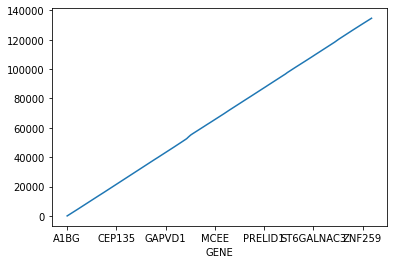

In [ ]:
vis = max_expression.cumsum()
vis.plot()

In [ ]:
pg.normality(max_expression)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
0,0.896759,0.0,False


**Disregard everything between these two asterisks ***

It's not a normal distribution, perhaps all of our data is quite important? Let's look at the smallest 1% of the data

In [ ]:
percentage = 1
print(max_expression.nsmallest(int(len(max_expression) * percentage/100)))

GENE
IFNA1          4.62
AGT            5.46
CEACAM6        5.82
MT1HL1         6.40
MINOS1-NBL1    6.58
               ... 
LYSMD1         8.23
GPR113         8.24
PPP1R27        8.24
SDC1           8.24
SPRED1         8.24
Length: 123, dtype: float64


It seems that all of this data is quite relevant

 **and ***

In [ ]:
if(np.shape(T_GE)[0] != len(T_metadata)):
  print("flipping!")
  T_GE = T_GE.transpose()
else:
  print("no flip needed")

flipping!


In [ ]:
# T_GE.to_csv("T_GE_Clean.csv")
# T_metadata.to_csv("T_metadata_Clean.csv")

In [ ]:
# T_GE_Clean_ID = "1uR8C1l5qQiSNvMySsHES1fDxJOIclpTU"
# T_GE_Clean_file = drive.CreateFile({'id':T_GE_Clean_ID})
# T_GE_Clean_file.GetContentFile('T_GE_Clean.csv')
# T_GE_Clean = pd.read_csv("T_GE_Clean.csv")

In [ ]:
# T_metadata_Clean_ID = "1--Qye0OUX6pat14fXu8vLTaiyZOaUzrO"
# T_metadata_Clean_file = drive.CreateFile({'id':T_metadata_Clean_ID})
# T_metadata_Clean_file.GetContentFile('T_metadata_Clean.csv')
# T_metadata_Clean = pd.read_csv("T_metadata_Clean.csv")

Rather than using standard deviations to find the most important data we will use PCA

First we will use two principal components in order to obtain a nice visual representation of the clusters

In [ ]:
pca = PCA(n_components=2)

#reducing the gene expression data
principalComponents_T_GE = pca.fit_transform(T_GE)
principalDf_T_GE = pd.DataFrame(data = principalComponents_T_GE, columns = ['principal component 1', 'principal component 2'])


# #reducing the metadata 
# principalComponents_T_metadata = pca.transform(T_metadata)
# principalDf_T_metadata = pd.DataFrame(data = principalComponents_T_metadata, columns = ['principal component 1', 'principal component 2'])

In [ ]:
principalDf_T_GE

,principal component 1,principal component 2
0,-13.075878,36.619034
1,-19.370596,38.031378
2,-51.025013,42.871910
3,79.525573,26.430344
4,27.684541,33.343260
...,...,...
16286,33.800958,-33.912860
16287,10.824580,-21.074145
16288,47.044409,-12.258513
16289,81.846614,-17.433021


Here it wouldn't let us concatenate if the index was different, and before it was C001, C002 etc i reset the index and then dropped the name (which was C001 etc)

In [ ]:
cluster_all_df =  T_metadata[['cluster_all']].reset_index().drop(["NAME"], axis=1)

In [ ]:
cluster_all_df

,cluster_all
0,G01
1,G01
2,G01
3,G01
4,G01
...,...
16286,G11
16287,G11
16288,G11
16289,G11


In [ ]:
finalDf = pd.concat([principalDf_T_GE, cluster_all_df], axis=1, sort=False)
finalDf

NameError: ignored

Now to create the visual model:

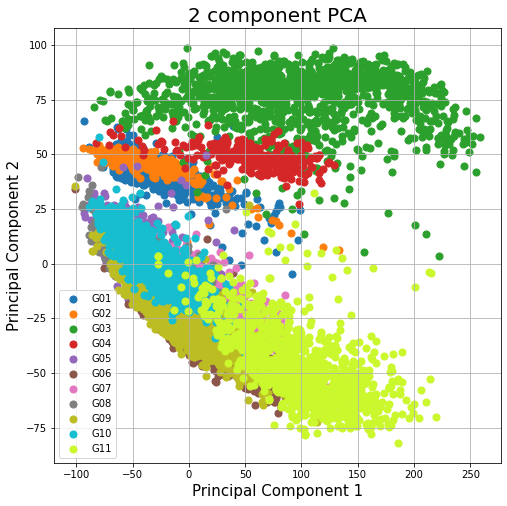

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ["G01", "G02", "G03", "G04", "G05", "G06", "G07", "G08", "G09", "G10", "G11"]
# colors = ['r', 'g', 'b']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#cbf72d']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cluster_all'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


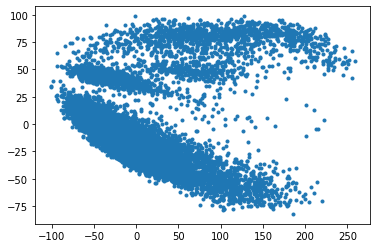

In [ ]:
T_metadata[['cluster_all']# plt.plot(principalDf["principal component 1"], principalDf["principal component 2"], ".")

Variance Ratio:

In [ ]:
pca.explained_variance_ratio_

array([0.04919983, 0.01897754])

In [ ]:
100 * (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])

6.817736626295728

Note that this only accounts for 7% of the data, only used 2 dimensions in order to gain greater insight

Now we want to use PCA to speed up our training 

We want to see what % of the data we should keep. To do this we shall try finding the "elbow" of the grahp where the number of components is plotted against the percentage

In [ ]:
num_components = np.array([])
for i in range(1, 11):
  delta = (i/2)/10
  pca = PCA(1 - delta)
  pca.fit(train_T)
  num_components = np.append(pca.n_components_, num_components)
  print(i)

NameError: ignored

In [ ]:
len(num_components)

10

In [ ]:
index_of_PCA =  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
len(index_of_PCA)

10

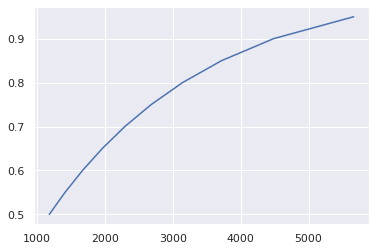

In [ ]:
plt.plot(num_components, index_of_PCA)

This isn't enough information to help us find an elbow, lets go through more percentages

In [ ]:
num_components_p2 = np.array([])
for i in range(11, 20):
  delta = (i/2)/10
  pca = PCA(1 - delta)
  pca.fit(train_T)
  num_components_p2 = np.append(pca.n_components_, num_components_p2)
  print(i)

11
12
13
14
15
16
17
18
19


In [ ]:
num_components_p2 = np.flip(num_components_p2)
num_components_p3 = np.append(num_components_p2, num_components)

In [ ]:
index_of_PCA =  [0.05, 0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

In [ ]:
print(len(index_of_PCA))
print(len(num_components_p3))

19
19


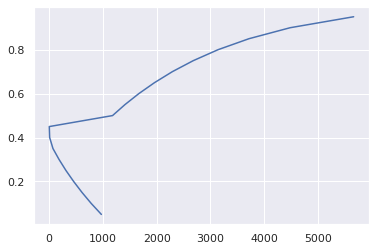

In [ ]:
plt.plot(num_components_p3, index_of_PCA)

In [ ]:
pd.DataFrame(num_components_p3, index_of_PCA)

,0
0.05,971.0
0.10,782.0
0.15,611.0
0.20,455.0
0.25,312.0
0.30,184.0
0.35,70.0
0.40,9.0
0.45,2.0
0.50,1179.0


In [ ]:
pd.DataFrame(num_components_p3, index_of_PCA).to_csv("PCA_eblow_info_df.csv")

Looking at the difference

In [ ]:
for i in reversed(range(len(num_components_p3) - 1)):
  print(num_components_p3[i + 1] - num_components_p3[i])

1182.0
766.0
575.0
462.0
388.0
332.0
292.0
258.0
231.0
1177.0
-7.0
-61.0
-114.0
-128.0
-143.0
-156.0
-171.0
-189.0


First we must find how many features  to keep based on comulative variance plot

It seems as if 75% may be a good place to do the PCA

In [ ]:
pca = PCA(0.75)  # minimum number of principal components such that 75% of the variance is retained.

In [ ]:
train_T, test_T, train_lbl, test_lbl = train_test_split(T_GE, cluster_all_df, test_size = 0.3, random_state = 1)

In [ ]:
pca.fit(train_T)

PCA(copy=True, iterated_power='auto', n_components=0.75, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.n_components_ 

2680

In [ ]:
train_T = pca.transform(train_T)
test_T = pca.transform(test_T)

In [ ]:
T_GE_PCA_75 = pca.transform(T_GE)

Forgot to create the labled df so here:

In [ ]:
labels = []
for i in range(len(cluster_all_df)):
  labels.append(int(cluster_all_df.loc[i].cluster_all.strip("G")))

In [ ]:
cluster_all_df

,cluster_all
0,G01
1,G01
2,G01
3,G01
4,G01
...,...
16286,G11
16287,G11
16288,G11
16289,G11


In [ ]:
cluster_all_df['ind'] = list(T_GE.index)

In [ ]:
cluster_all_df["labels"] = labels

In [ ]:
cluster_all_df = cluster_all_df.drop(["cluster_all"], axis =1)

In [ ]:
cluster_all_df = cluster_all_df.set_index('ind')

In [ ]:
cluster_all_df

,labels
ind,
C00001,1
C00002,1
C00003,1
C00004,1
C00005,1
...,...
C16287,11
C16288,11
C16289,11


In [ ]:
cluster_all_df.index.name = ""

In [ ]:
cluster_all_df

,labels
,
C00001,1
C00002,1
C00003,1
C00004,1
C00005,1
...,...
C16287,11
C16288,11
C16289,11


In [ ]:
T_GE["Labels"] = labels

In [ ]:
T_GE_Labeled = T_GE

In [ ]:
T_GE_Labeled

GENE,A1BG,A2M,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,ABAT,ABCA1,ABCA2,ABCA5,ABCA6,ABCA7,ABCB1,ABCB10,ABCB4,ABCB6,ABCB7,ABCB8,ABCC1,ABCC10,ABCC3,ABCC4,ABCC5,ABCC6,ABCD1,ABCD2,ABCD3,ABCD4,ABCE1,...,ZNHIT6,ZNRD1,ZNRF1,ZNRF2,ZP3,ZRANB1,ZRANB2,ZRANB3,ZRSR1,ZRSR2,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN25,ZSCAN29,ZSCAN30,ZSCAN32,ZSCAN5A,ZSCAN9,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM7,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,Labels
C00001,0.0,6.06,5.56,3.77,3.78,0.00,5.87,5.92,0.00,7.55,8.45,0.0,0.00,0.0,0.00,6.13,6.26,7.4,0.0,0.00,0.00,0.00,0.00,0.0,6.16,4.11,0.0,5.63,0.00,0.00,0.00,6.02,0.0,3.82,0.0,0.00,4.67,5.33,0.00,0.00,...,8.03,0.00,0.0,3.33,0.00,0.0,5.12,0.00,0.0,0.0,6.47,0.0,0.0,0.0,0.00,0.0,0.00,4.12,2.99,0.0,0.0,0.0,0.00,3.64,0.0,0.00,0.00,0.0,4.38,0.0,0.0,4.91,0.00,0.0,0.0,0.0,0.00,4.20,0.00,1
C00002,0.0,0.00,9.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,1.57,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.26,6.60,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,8.02,0.00,1
C00003,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,7.58,0.0,0.00,0.00,0.0,3.65,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,5.6,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,9.82,0.00,0.0,0.0,0.0,6.32,0.00,0.00,1
C00004,0.0,0.00,7.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.92,0.0,0.00,0.0,7.05,0.00,6.04,0.0,0.0,0.00,0.00,0.00,3.97,0.0,0.00,0.00,0.0,0.00,1.21,0.00,2.62,0.00,0.0,0.00,0.0,0.00,0.00,6.94,5.22,8.79,...,7.07,11.45,0.0,0.00,0.00,0.0,0.00,3.97,0.0,4.1,0.00,0.0,0.0,0.0,5.27,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,5.52,6.07,1
C00005,0.0,0.00,0.00,0.00,5.78,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,7.15,0.00,0.00,0.0,0.0,0.00,0.00,0.00,7.75,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,7.66,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,7.42,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C16287,0.0,0.00,6.31,0.00,0.00,3.14,6.82,0.00,0.00,0.00,8.58,0.0,0.00,0.0,8.33,0.00,0.00,0.0,0.0,3.52,0.00,0.00,0.00,0.0,0.00,0.00,0.0,8.27,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.68,0.0,1.82,0.0,0.0,0.00,8.79,0.0,0.0,0.0,0.00,0.00,0.00,11
C16288,0.0,0.00,0.00,0.00,0.00,0.00,7.08,0.00,7.40,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,3.89,0.00,0.00,0.00,...,0.00,4.40,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,11
C16289,0.0,0.00,7.59,0.00,5.96,0.00,3.91,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,7.83,0.0,0.0,0.00,4.91,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,7.79,0.00,0.0,0.00,0.0,6.21,0.00,0.00,8.23,0.00,...,0.00,0.00,0.0,6.54,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,2.16,0.00,0.00,0.0,0.0,0.0,0.99,7.13,0.0,0.00,0.00,0.0,1.86,0.0,0.0,0.00,8.42,0.0,0.0,0.0,0.00,0.00,0.00,11
C16290,0.0,0.00,7.83,0.00,0.00,0.00,0.00,0.00,8.89,7.79,0.00,0.0,8.13,0.0,7.44,0.00,8.81,0.0,0.0,0.00,0.00,0

In [ ]:
T_GE = T_GE.drop(["Labels"], axis = 1)

In [ ]:
T_GE

GENE,A1BG,A2M,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARS,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,ABAT,ABCA1,ABCA2,ABCA5,ABCA6,ABCA7,ABCB1,ABCB10,ABCB4,ABCB6,ABCB7,ABCB8,ABCC1,ABCC10,ABCC3,ABCC4,ABCC5,ABCC6,ABCD1,ABCD2,ABCD3,ABCD4,ABCE1,...,ZNHIT3,ZNHIT6,ZNRD1,ZNRF1,ZNRF2,ZP3,ZRANB1,ZRANB2,ZRANB3,ZRSR1,ZRSR2,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN2,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN25,ZSCAN29,ZSCAN30,ZSCAN32,ZSCAN5A,ZSCAN9,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM6,ZSWIM7,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
C00001,0.0,6.06,5.56,3.77,3.78,0.00,5.87,5.92,0.00,7.55,8.45,0.0,0.00,0.0,0.00,6.13,6.26,7.4,0.0,0.00,0.00,0.00,0.00,0.0,6.16,4.11,0.0,5.63,0.00,0.00,0.00,6.02,0.0,3.82,0.0,0.00,4.67,5.33,0.00,0.00,...,0.00,8.03,0.00,0.0,3.33,0.00,0.0,5.12,0.00,0.0,0.0,6.47,0.0,0.0,0.0,0.00,0.0,0.00,4.12,2.99,0.0,0.0,0.0,0.00,3.64,0.0,0.00,0.00,0.0,4.38,0.0,0.0,4.91,0.00,0.0,0.0,0.0,0.00,4.20,0.00
C00002,0.0,0.00,9.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,1.57,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.26,6.60,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,8.02,0.00
C00003,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,7.58,0.0,0.00,0.00,0.0,3.65,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,5.6,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,9.82,0.00,0.0,0.0,0.0,6.32,0.00,0.00
C00004,0.0,0.00,7.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.92,0.0,0.00,0.0,7.05,0.00,6.04,0.0,0.0,0.00,0.00,0.00,3.97,0.0,0.00,0.00,0.0,0.00,1.21,0.00,2.62,0.00,0.0,0.00,0.0,0.00,0.00,6.94,5.22,8.79,...,7.53,7.07,11.45,0.0,0.00,0.00,0.0,0.00,3.97,0.0,4.1,0.00,0.0,0.0,0.0,5.27,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,5.52,6.07
C00005,0.0,0.00,0.00,0.00,5.78,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,7.15,0.00,0.00,0.0,0.0,0.00,0.00,0.00,7.75,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,7.66,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,7.42,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C16287,0.0,0.00,6.31,0.00,0.00,3.14,6.82,0.00,0.00,0.00,8.58,0.0,0.00,0.0,8.33,0.00,0.00,0.0,0.0,3.52,0.00,0.00,0.00,0.0,0.00,0.00,0.0,8.27,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.68,0.0,1.82,0.0,0.0,0.00,8.79,0.0,0.0,0.0,0.00,0.00,0.00
C16288,0.0,0.00,0.00,0.00,0.00,0.00,7.08,0.00,7.40,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,3.89,0.00,0.00,0.00,...,4.71,0.00,4.40,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00
C16289,0.0,0.00,7.59,0.00,5.96,0.00,3.91,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,7.83,0.0,0.0,0.00,4.91,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,7.79,0.00,0.0,0.00,0.0,6.21,0.00,0.00,8.23,0.00,...,0.00,0.00,0.00,0.0,6.54,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,2.16,0.00,0.00,0.0,0.0,0.0,0.99,7.13,0.0,0.00,0.00,0.0,1.86,0.0,0.0,0.00,8.42,0.0,0.0,0.0,0.00,0.00,0.00
C16290,0.0,0.00,7.83,0.00,0.00,0.00,0.00,0.00,8.89,7.79,0.00,0.0,8.13,0.0,7.44,0.00,8.8

In [ ]:
labels_PCA_75 = pca.transform(cluster_all_df)

Saving this to drive to access later:

In [ ]:
pd.DataFrame(train_T).to_csv("PCA_.75_train_T")

KeyboardInterrupt: ignored

In [ ]:
pd.DataFrame(test_T).to_csv("PCA_.75_test_T")

In [ ]:
pd.DataFrame(T_GE_PCA_75).to_csv("T_GE_PCA_75")

In [ ]:
T_GE.to_csv("T_GE")

In [ ]:
T_GE_Labeled.to_csv("T_GE_Labeled")

In [ ]:
pd.DataFrame(labels_PCA_75).to_csv("labels_PCA_75")

In [ ]:
cluster_all_df.to_csv("labels_raw")

Now retreiving these PCA files in order to save time in re-running the preprocessing: 

# Installing the now pre-processed data

we do this to prevent using extra space and to save time

In [5]:
labels_df_ID = "1hjhQkze5In5WGcMZl-S-kEroSS0zRHgp"
labels_df_file = drive.CreateFile({'id':labels_df_ID})
labels_df_file.GetContentFile('labels_raw')
labels_df = pd.read_csv("labels_raw")

In [6]:
labels_df = labels_df.set_index("Unnamed: 0")
labels_df.index.name = ""

In [7]:
T_GE_PCA_75_ID = "1-LIQQ7jU40aItkvYWeFXtPzJ0if9LxSB"
T_GE_PCA_75_file = drive.CreateFile({'id':T_GE_PCA_75_ID})
T_GE_PCA_75_file.GetContentFile('T_GE_PCA_75')
T_GE_PCA_75 = pd.read_csv("T_GE_PCA_75")

In [8]:
T_GE_PCA_75 = T_GE_PCA_75.drop("Unnamed: 0", axis = 1)

In [9]:
train_PCA, test_PCA, train_lbl_PCA, test_lbl_PCA = train_test_split(T_GE_PCA_75, labels_df, test_size = 0.3, random_state = 1)

In [ ]:
#T_GE_PCA_75["ind"] = labels_df.index

In [ ]:
def confusion_matrix_T (lbl, pred):
  cm = metrics.confusion_matrix(lbl, pred)
  plt.figure(figsize=(11,11))
  plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
  plt.title('Confusion Matrix', size = 15)
  plt.colorbar()
  tick_marks = np.arange(11)
  plt.xticks(tick_marks, ["G01", "G02", "G03", "G04", "G05", "G06", "G07", "G08", "G09", "G10", "G11"], rotation = 45, size = 10)
  plt.yticks(tick_marks, ["G01", "G02", "G03", "G04", "G05", "G06", "G07", "G08", "G09", "G10", "G11"], size = 10)
  plt.tight_layout()
  plt.ylabel('Actual', size = 15)
  plt.xlabel('Predicted', size = 15)
  width, height = cm.shape

  for x in range(width):
    for y in range(height):
      plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

#Logistic Regression

In [ ]:
pipe = Pipeline([("model", linear_model.LogisticRegression())])
params = [{"model": [linear_model.LogisticRegression()],
           "model__penalty": ["l1", "l2"],
           "model__C": np.logspace(0, 4, num=5)},
          {"model": [linear_model.LogisticRegression()],
            "model__penalty": ['l2'],
            "model__C": np.logspace(0, 4,  num=5),
            "model__solver":['newton-cg','saga','sag','liblinear']}]

lgr_grid_search = GridSearchCV(pipe, params, cv=5,n_jobs=-1, verbose=1)
lgr = lgr_grid_search.fit(train_PCA, train_lbl_PCA)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 97.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
lgr_best_model = lgr.best_estimator_
lgr_best_model

Pipeline(memory=None,
         steps=[('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
lgr_best_model_pred = lgr_best_model.predict(test_PCA)
lgr_best_model.score(test_PCA, test_lbl_PCA)

0.9484451718494271

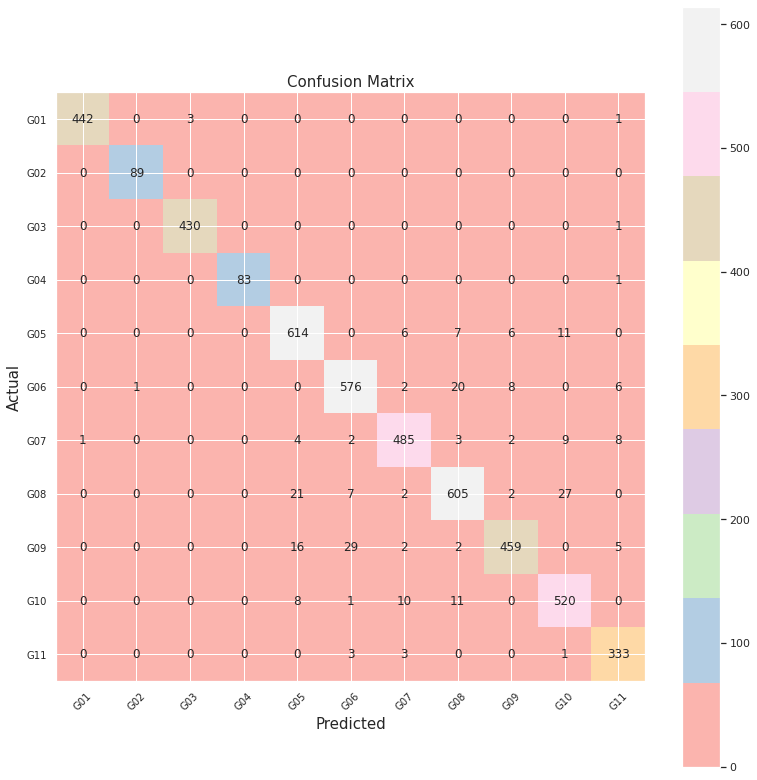

In [ ]:
confusion_matrix_T(test_lbl_PCA, lgr_best_model_pred)

hgfdshklj

In [ ]:
lm = linear_model.LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)

In [ ]:
lm.fit(train_PCA, train_lbl_PCA)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.001, verbose=0,
                   warm_start=False)

In [ ]:
T_pred = lm.predict(test_PCA)

In [ ]:
print(metrics.accuracy_score(test_lbl_PCA, T_pred))

0.9470130932896891


We will also want to see how well the model peforms; here is the function for desciprtive stastics

In [ ]:
def model_stats(y_test, y_pred):
  accuracy = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  print("Accuracy: " + str(accuracy) + "\nPrecision: " + str(precision) + "\nRecall: " + str(recall))
  

  

Now let's test the model

Computing a confusion matrix:

We will want to create more confusion matrices in the future, and thus we will create a function to call when we need it.

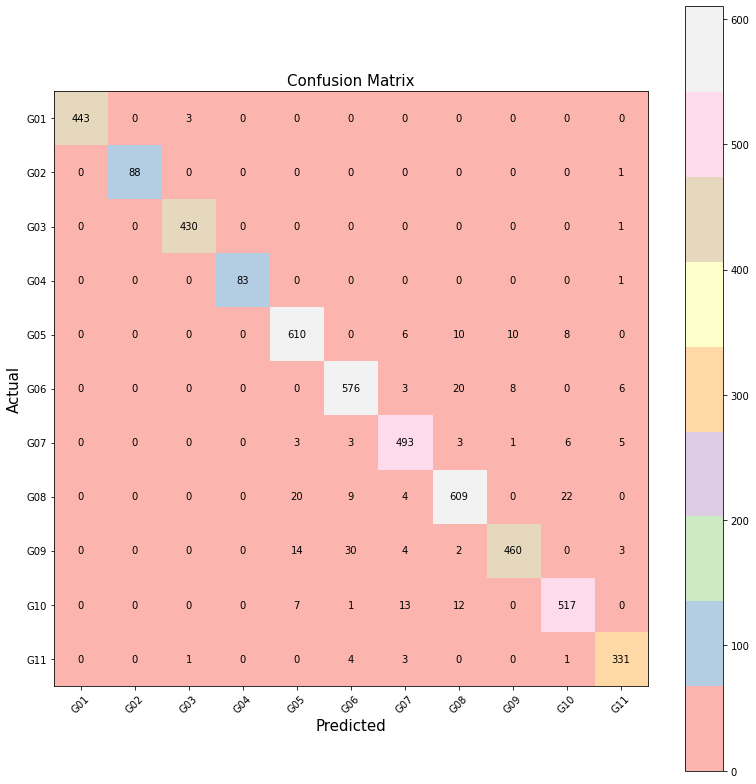

In [ ]:
confusion_matrix_T(train_lbl_PCA, T_pred)

#K Nearest Neighbors

In [ ]:
hypr_params = {'n_neighbors': np.logspace(1.8, 2.6, num=5, dtype = int)}
KNN = KNeighborsClassifier()
GridSearch_KNN = GridSearchCV(KNN, hypr_params, cv=5)

pca_n_components = [2, 3, 4]
for i in range(len(pca_n_components)):
  pca = PCA(n_components=pca_n_components[i])
  pca.fit(T_GE_PCA_75)
  pca.transform(T_GE_PCA_75)
  train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(T_GE_PCA_75, labels_df, test_size = 0.3, random_state = 1)
  GridSearch_KNN.fit(train_x_PCA, train_y_PCA)
  best_model = GridSearch_KNN.best_estimator_
  print("i: " + str(i) + "\nbest model: " + str(best_model) + "\n score of best model: " + str(best_model.score(test_x_PCA, test_y_PCA)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

i: 0
best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=398, p=2,
                     weights='uniform')
 score of best model: 0.18985270049099837


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

i: 1
best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=398, p=2,
                     weights='uniform')
 score of best model: 0.18985270049099837


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

i: 2
best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=398, p=2,
                     weights='uniform')
 score of best model: 0.18985270049099837


In [ ]:
pca = PCA(n_components=100)
pca.fit(T_GE_PCA_75)
pca.transform(T_GE_PCA_75)
train_x_PCA, test_x_PCA, train_y_PCA, test_y_PCA = train_test_split(T_GE_PCA_75, labels_df, test_size = 0.3, random_state = 1)
GridSearch_KNN.fit(train_x_PCA, train_y_PCA)
best_model = GridSearch_KNN.best_estimator_
print("\nbest model: " + str(best_model) + "\n score of best model: " + str(best_model.score(test_x_PCA, test_y_PCA)))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when


best model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=398, p=2,
                     weights='uniform')
 score of best model: 0.18985270049099837


Note we will be using the accuracy as a means of seeing how well the k value is. For this accuracy computation we will use cross-validation to avoid basing our k on a high-variance estimate

In [ ]:
acc = np.array([])
for i in range (1, 30):
  KNN = KNeighborsClassifier(n_neighbors=i)
  score = cross_val_score(KNN, T_GE_PCA_75, labels_df, cv = 5)
  acc = np.append(acc, score.mean())
  print(*[i, ":", score.mean()])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

1 : 0.40150727710447587


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

2 : 0.35534890300477817


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

3 : 0.3851784104122296


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

4 : 0.41900003597724655


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

5 : 0.4232335219030795


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

6 : 0.4280820492187569


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

7 : 0.4365526187950787


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

8 : 0.44563732562101716


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

9 : 0.44692653540434185


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

10 : 0.45220532045084205


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

11 : 0.4515296828294918


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

12 : 0.453187047211754


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

13 : 0.450608891352671


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

14 : 0.4533099537739472


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

15 : 0.4498724126285033


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

16 : 0.4506091173877279


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

17 : 0.45067033521564026


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

18 : 0.45171380721959736


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

19 : 0.4502407932624977


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

20 : 0.45036358680716254


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

21 : 0.4475400698938068


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

22 : 0.4488290536420746


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

23 : 0.447847006664832


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


for some reason the code stopped, however since we printed out the first 23 values, we will manually add these in

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(range(1,30),acc,color='grey', linestyle='dashed', marker='o', markerfacecolor='darkcyan', markersize=10)
plt.title('Accuracy vs. Value of K')
plt.xlabel('Value of K')
plt.ylabel('Accuracy')

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=1000)
score = cross_val_score(KNN, T_GE_PCA_75, labels_df, cv = 5)
score.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

0.6448334131048721

3258

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=(int(len(labels_df)/5)))
score = cross_val_score(KNN, T_GE_PCA_75, labels_df, cv = 5)
score.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

0.455160069550987

In [ ]:
testing_neighbors = [50, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000, 5000, 10000, 15000]
better_acc = np.array([])
for i in range(len(testing_neighbors)):
  KNN = KNeighborsClassifier(n_neighbors=testing_neighbors[i])
  score = cross_val_score(KNN, T_GE_PCA_75, labels_df, cv = 5)
  better_acc = np.append(better_acc, score.mean())
  print(*[i, ":", score.mean()])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

0 : 0.4574230383594678


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

1 : 0.622487756905324


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

2 : 0.6558819878502391


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

3 : 0.6448334131048721


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

4 : 0.6210782587992151


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

5 : 0.6088017297709455


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

6 : 0.5766987617611219


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

7 : 0.5216375260387676


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

8 : 0.4740657170557201


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

9 : 0.3560859091440787


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

10 : 0.1810207592479889


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


ValueError: ignored

from the previous runs it seems like having between 500 and 1000 yielded the highest accuracy

In [ ]:
testing_neighbors = [500, 600, 700, 750, 800, 900, 1000]
better_acc = np.array([])
for i in range(len(testing_neighbors)):
  KNN = KNeighborsClassifier(n_neighbors=testing_neighbors[i])
  score = cross_val_score(KNN, T_GE_PCA_75, labels_df, cv = 5)
  better_acc = np.append(better_acc, score.mean())
  print(*[i, ":", score.mean()])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

0 : 0.622487756905324


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

1 : 0.6438499345722691


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

2 : 0.6554520880082564


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

3 : 0.6558819878502391


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

4 : 0.6548998466917227


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

5 : 0.6529358845910206


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

6 : 0.6448334131048721


In [ ]:
better_acc

array([0.62248776, 0.64384993, 0.65545209, 0.65588199, 0.65489985,
       0.65293588, 0.64483341])

Text(0, 0.5, 'Accuracy')

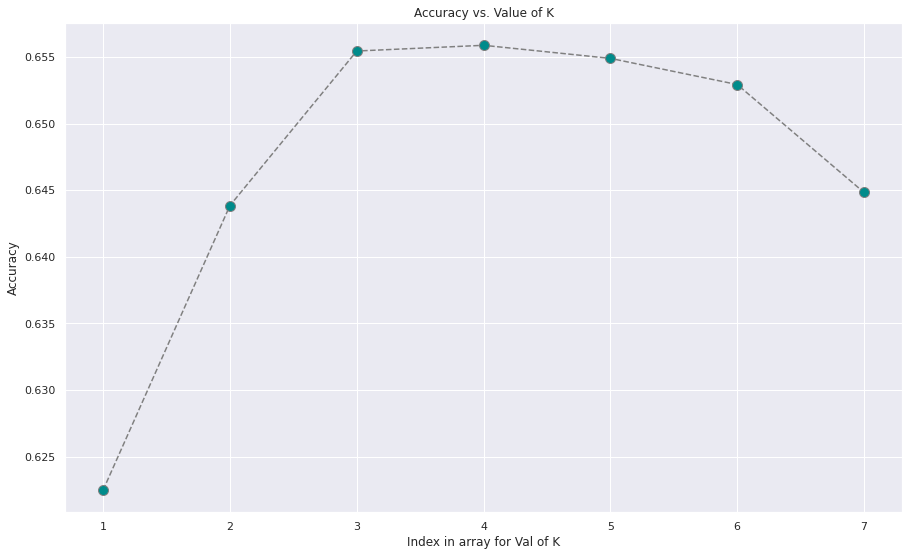

In [ ]:
plt.figure(figsize=(15,9))
plt.plot(range(1,8),better_acc,color='grey', linestyle='dashed', marker='o', markerfacecolor='darkcyan', markersize=10)
plt.title('Accuracy vs. Value of K')
plt.xlabel('Index in array for Val of K')
plt.ylabel('Accuracy')

In [ ]:
hypr_params = {'n_neighbors': (710, 730, 750, 770, 790)}
KNN = KNeighborsClassifier()
GSearch = GridSearchCV(KNN, hypr_params, cv=5)

In [ ]:
GSearch.fit(train_PCA, train_lbl_PCA)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': (710, 730, 750, 770, 790)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
GSearch.best_params_ 

{'n_neighbors': 790}

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=790)
KNN.fit(train_PCA, train_lbl_PCA)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=790, p=2,
                     weights='uniform')

In [ ]:
KNN_pred = KNN.predict(test_PCA)

0.4693126022913257


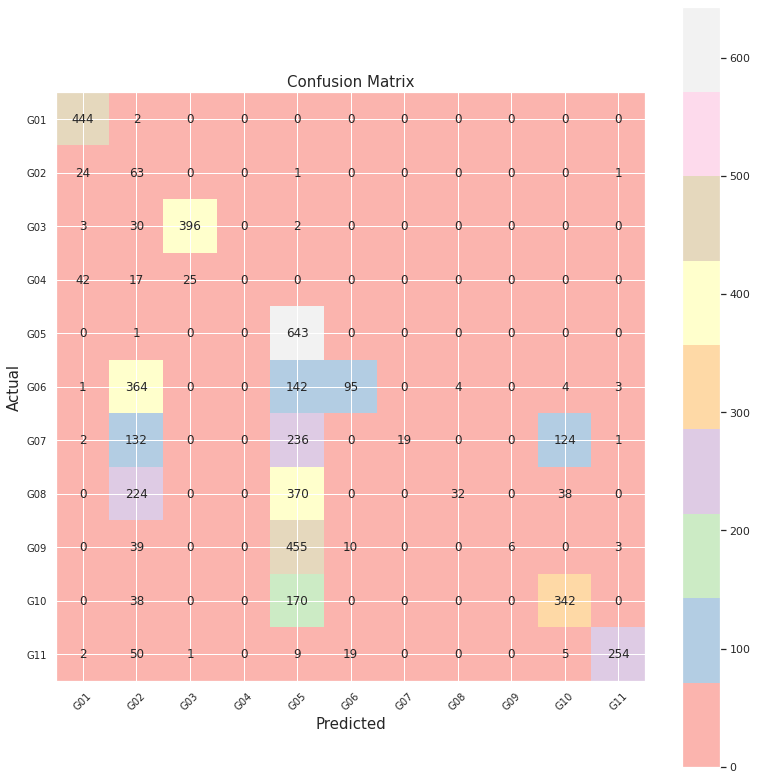

In [ ]:
print(metrics.accuracy_score(test_lbl_PCA, KNN_pred))
confusion_matrix_T(test_lbl_PCA, KNN_pred)

#Gaussian Naive Bayes

In [ ]:
GNB_params_v_smoothing = {"var_smoothing": np.logspace(-64, -25, num=40)}
GNB = GaussianNB()
GNB_grid_search = GridSearchCV(GNB, GNB_params_v_smoothing, cv = 5)

In [ ]:
GNB_grid_search.fit(train_PCA, train_lbl_PCA)
GNB_grid_search.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

{'var_smoothing': 1e-64}

In [ ]:
best_GNB_model = GNB_grid_search.best_estimator_
best_GNB_model_pred = best_GNB_model.predict(test_PCA)
best_GNB_model.score(test_PCA, test_lbl_PCA)

0.3608837970540098

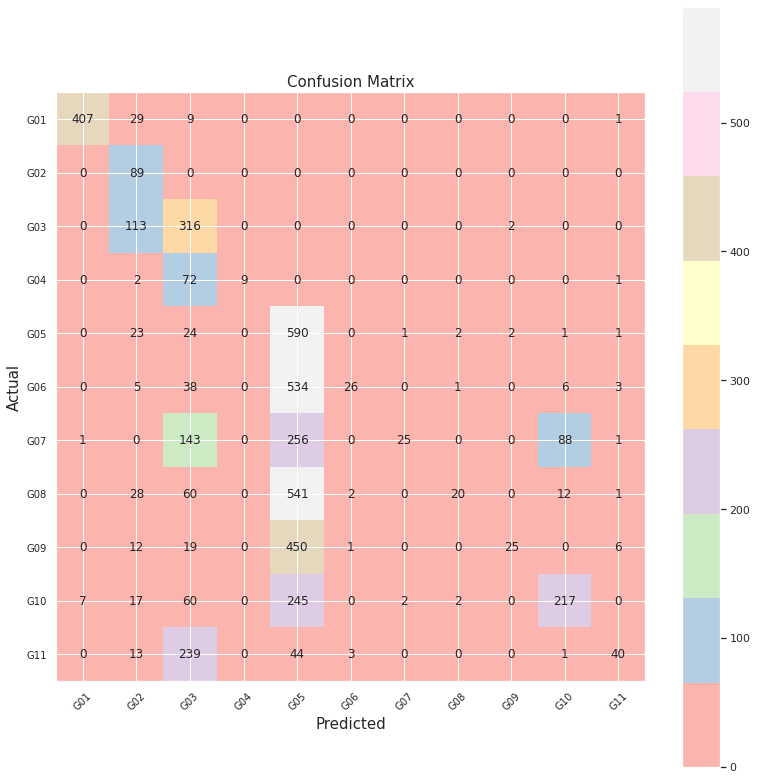

In [ ]:
confusion_matrix_T(test_lbl_PCA, best_GNB_model_pred)

We will try this again but with using a standard scaler to see if this changes anything in the notebook titled: [Creating T-cells GNB, Standard Scaling + PCA files.ipynb](https://github.com/rnayebi21/PolygenceMLResearch-scRNAseq/blob/main/Creating_T_cells_GNB%2C_Standard_Scaling_%2B_PCA_files.ipynb)

When running this notebook we get a score of 52.6% where the confusion matrix looks like this:
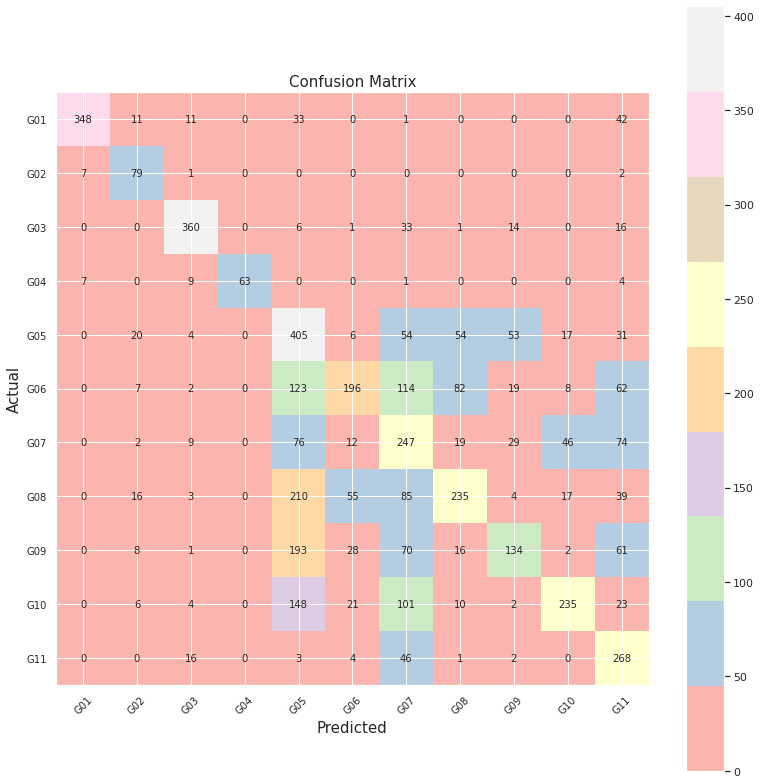

#Support Vector Machine (with grid search cv)

In [ ]:
SVM_pipe = Pipeline([("model", svm.SVC())])
SVM_params = [{"model": [svm.SVC()],
           "model__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
           "model__C": np.logspace(-5, 5, num=5), 
           "model__gamma": ['auto', 'scale']},
          {"model": [svm.SVC()],
            "model__kernel": ['poly'],
            "model__degree": [1,3,5],
            "model__C": np.logspace(-5, 5, num=5),
            "model__gamma": ['auto', 'scale']}]

SVM_grid_search = GridSearchCV(SVM_pipe, SVM_params, cv=5,n_jobs=-1, verbose=1)
SVM = SVM_grid_search.fit(train_PCA, train_lbl_PCA)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 125.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 502.8min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 1015.9min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
SVM_best_model = SVM.best_estimator_
SVM_best_model

Pipeline(memory=None,
         steps=[('model',
                 SVC(C=316.22776601683796, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [ ]:
SVM_best_model_pred = SVM_best_model.predict(test_PCA)
SVM_best_model.score(test_PCA, test_lbl_PCA)

0.94189852700491

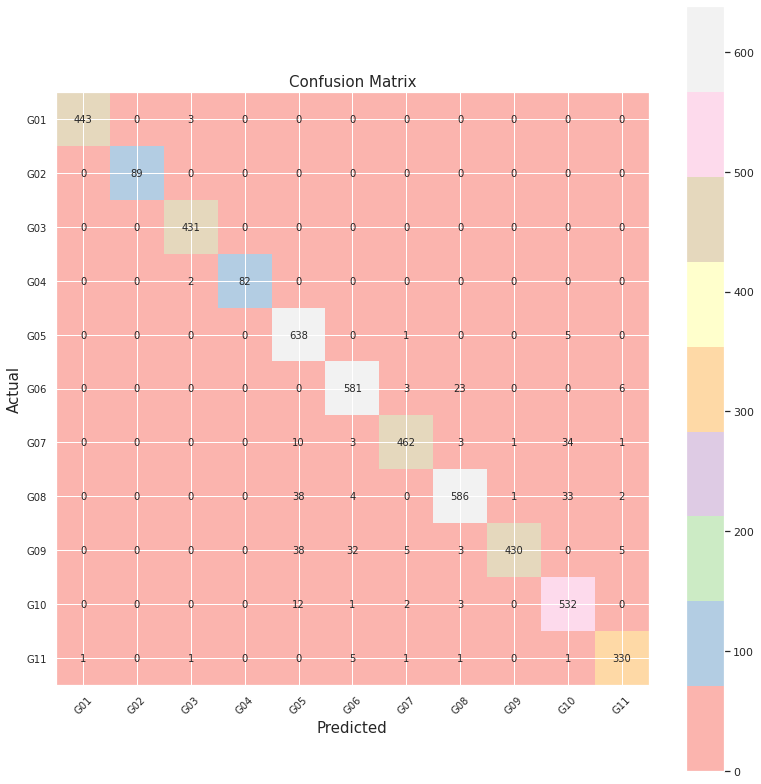

In [ ]:
confusion_matrix_T(test_lbl_PCA, SVM_best_model_pred)

#Random Forest (also with grid search cv)

In [1]:
RFC_params = {"n_estimators": [10, 100, 500, 1000],
                "max_features": ['sqrt', 'log2', None]}
RFC = RandomForestClassifier(n_jobs=-1)
RFC_grid_search = GridSearchCV(RFC, RFC_params, cv = 5)
RFC_grid_search.fit(train_PCA, train_lbl_PCA)

In [ ]:
RFC_grid_search.best_params_

In [ ]:
best_RFC_model = RFC_grid_search.best_estimator_
best_RFC_model_pred = best_RFC_model.predict(test_PCA)
best_RFC_model.score(test_PCA, test_lbl_PCA)

In [ ]:
confusion_matrix_Stem(test_lbl_PCA, best_RFC_model_pred)

#Stream Line Time!

Note that we could have done the following code in a very streamlined process. However we would not nearly gain as much information from each individual model on things like how well they performed. But if we just wanted the best model we could have done something like this usnig a pipeline:


```
# Re-loading the files in
T_cell_metadata_ID = "1Fo2aLizvnvpOPK10MRJFyWBddFkBPuaf"
T_file = drive.CreateFile({'id':T_cell_metadata_ID})
T_file.GetContentFile('cells_all_scp.txt')
T_metadata = pd.read_csv("cells_all_scp.txt", sep = "\t")

T_gene_expression_ID = "18yyfxNJhE5R1JDO3Cw4hyqM61luBs8RG"
T_GE_file = drive.CreateFile({'id':T_gene_expression_ID})
T_GE_file.GetContentFile('tpm_all_scp.txt')
T_GE = pd.read_csv("tpm_all_scp.txt", sep = "\t")

labels_df_ID = "1hjhQkze5In5WGcMZl-S-kEroSS0zRHgp"
labels_df_file = drive.CreateFile({'id':labels_df_ID})
labels_df_file.GetContentFile('labels_raw')
labels_df = pd.read_csv("labels_raw")

# Cleaning things to have proper dimensions
T_metadata.index = T_metadata.NAME
T_metadata = T_metadata.drop("NAME", axis = 1)
T_metadata = T_metadata.drop("TYPE", axis = 0)

T_GE.index = T_GE.GENE
T_GE = T_GE.drop("GENE", axis = 1)

if(np.shape(T_GE)[0] != len(T_metadata)):
  print("flipping!")
  T_GE = T_GE.transpose()
else:
  print("no flip needed")


labels_df = labels_df.set_index("Unnamed: 0")
labels_df.index.name = ""

# Splitting the data (70, 30)
train_X, test_X, train_Y, test_Y = train_test_split(T_GE, labels_df, test_size = 0.3, random_state = 1)

# Creating Confusion Matrix Function
def confusion_matrix_T (lbl, pred):
  cm = metrics.confusion_matrix(lbl, pred)
  plt.figure(figsize=(11,11))
  plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
  plt.title('Confusion Matrix', size = 15)
  plt.colorbar()
  tick_marks = np.arange(11)
  plt.xticks(tick_marks, ["G01", "G02", "G03", "G04", "G05", "G06", "G07", "G08", "G09", "G10", "G11"], rotation = 45, size = 10)
  plt.yticks(tick_marks, ["G01", "G02", "G03", "G04", "G05", "G06", "G07", "G08", "G09", "G10", "G11"], size = 10)
  plt.tight_layout()
  plt.ylabel('Actual', size = 15)
  plt.xlabel('Predicted', size = 15)
  width, height = cm.shape

  for x in range(width):
    for y in range(height):
      plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

#Creating the pipeline
pipe = Pipeline([("model", KNeighborsClassifier())])
params = [{"model": [linear_model.LogisticRegression()],
           "model__penalty": ["l1", "l2"],
           "model__C": np.logspace(0, 4, num=5)},
          {"model": [linear_model.LogisticRegression()],
            "model__penalty": ['l2'],
            "model__C": np.logspace(0, 4,  num=5),
            "model__solver":['newton-cg','saga','sag','liblinear']},
          {"model": [KNeighborsClassifier()],
           "model__n_neighbors": np.sort(np.append(np.logspace(1.5, 3.1, num=8), 650))},
          {"model": [GaussianNB()]},
          {"model": [RandomForestClassifier(oob_score=True)],
           "model_max_features" : ['sqrt', 'log2', None]
           "model__n_estimators": [20, 50, 100, 500, 1000]}]

grid_search = GridSearchCV(pipe, params, cv=5,n_jobs=-1, verbose=1)
best_model = grid_search.fit(train_PCA, train_lbl_PCA)

print(grid_search.best_params_)
```

and then we could have calcualted the confusion matrix on the `best_model` and calculated its score and everything.